In [0]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras
import os
import numpy as np
import pickle, bz2
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline

Using TensorFlow backend.


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
!wget nc https://github.com/cristianru31/dataset_kaggle/blob/master/kaggle_json.zip?raw=true -O kaggle_json.zip
!unzip kaggle_json.zip

In [0]:
from google.colab import files
!ls -lha kaggle.json
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!unzip alzheimers-dataset-4-class-of-images.zip

# Data pre-processing

In [0]:
TRAIN_DIR = 'Alzheimer_s Dataset/train/'
TEST_DIR = 'Alzheimer_s Dataset/test/'
IMAGE_SIZE = 176
CLASSES = ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented']

train_images = []
test_images = []
train_labels = []
test_labels = []

i=0
for klass in CLASSES:
  print(klass)

  #Train
  train_labels.append(np.ones(len(os.listdir(TRAIN_DIR + klass)))*i)
  for image in os.listdir(TRAIN_DIR + klass):
    img_aux=img.imread(TRAIN_DIR + klass + '/' + image)
    train_images.append(img_aux)

  #Test
  test_labels.append(np.ones(len(os.listdir(TEST_DIR + klass)))*i)
  for image in os.listdir(TEST_DIR + klass):
    img_aux=img.imread(TEST_DIR + klass + '/' + image)
    test_images.append(img_aux)

  i+=1

train_labels = np.concatenate(train_labels)
test_labels = np.concatenate(test_labels)

print('Data Train: ',np.shape(train_images))
print('Data Test: ',np.shape(test_images))
print('Labels Train: ',np.shape(train_labels))
print('Labels Test: ',np.shape(test_labels))


NonDemented
VeryMildDemented
MildDemented
ModerateDemented
Data Train:  (5121, 208, 176)
Data Test:  (1279, 208, 176)
Labels Train:  (5121,)
Labels Test:  (1279,)


In [0]:
x_train=np.array(train_images)
x_test=np.array(test_images)
y_train=np.array(train_labels)
y_test=np.array(test_labels)

In [0]:
y_test.shape, y_train.shape, x_test.shape, x_train.shape

((1279,), (5121,), (1279, 208, 176), (5121, 208, 176))

In [0]:
x_train=x_train.reshape((-1, x_train.shape[1], x_train.shape[2], 1))
x_test=x_test.reshape((-1, x_test.shape[1], x_test.shape[2], 1))
y_test.shape, y_train.shape, x_test.shape, x_train.shape

((1279,), (5121,), (1279, 208, 176, 1), (5121, 208, 176, 1))

# MODEL 1

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu")(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


In [0]:
num_classes = len(np.unique(train_labels))

model1 = get_model(num_classes=num_classes,reg=.0001, drop=0.4)
model1.summary()

using 4 classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 205, 173, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 102, 86, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 102, 86, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 83, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 41, 6

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model1', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model1.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,
          validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0427 20:08:16.789373 140301735864128 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0427 20:08:16.790581 140301735864128 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5121 samples, validate on 1279 samples
Epoch 1/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.2225 - accuracy: 0.5492
Epoch 00001: val_loss improved from inf to 1.22760, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model1/best_model1.hdf5
5121/5121 [==============================] - 123s 24ms/sample - loss: 1.2224 - accuracy: 0.5493 - val_loss: 1.2276 - val_accuracy: 0.5934
Epoch 2/20
5120/5121 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.8279
Epoch 00002: val_loss improved from 1.22760 to 1.08378, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model1/best_model1.hdf5
5121/5121 [==============================] - 123s 24ms/sample - loss: 0.4786 - accuracy: 0.8278 - val_loss: 1.0838 - val_accuracy: 0.5747
Epoch 3/20
5120/5121 [============================>.] - ETA: 0s - loss: 0.2731 - accuracy: 0.9061
Epoch 00003: val_loss did not improve from 1.08378
5121/5121 [==============================] - 

In [0]:
#Load the weights of the best stored model
model1.load_weights('best_model1.hdf5')

Normalized confusion matrix
[[0.609375   0.2375     0.153125   0.        ]
 [0.26116071 0.54464286 0.19419643 0.        ]
 [0.22346369 0.2122905  0.56424581 0.        ]
 [0.         0.5        0.5        0.        ]]


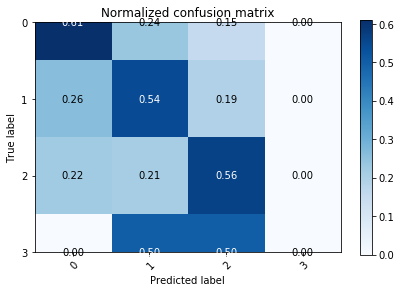

In [0]:
test_preds = model1.predict(x_test).argmax(axis=1)
class_names = np.array(['0', '1', '2', '3'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.5746677091477717
Accuracy Balanceado: 0.4295659167996808


# MODEL 2

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(128,(5,5), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
num_classes = len(np.unique(train_labels))

model2 = get_model(num_classes=num_classes ,reg=0.0001, drop=0.4)
model2.summary()

using 4 classes
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 205, 173, 32)      544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 102, 86, 32)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 102, 86, 32)       128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 99, 83, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 49, 41,

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model2', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model2.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True, validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0427 20:49:13.573211 140301735864128 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0427 20:49:13.574010 140301735864128 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5121 samples, validate on 1279 samples
Epoch 1/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.3569 - accuracy: 0.5102
Epoch 00001: val_loss improved from inf to 2.39377, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model2/best_model2.hdf5
5121/5121 [==============================] - 171s 33ms/sample - loss: 1.3568 - accuracy: 0.5103 - val_loss: 2.3938 - val_accuracy: 0.2306
Epoch 2/20
5120/5121 [============================>.] - ETA: 0s - loss: 0.8928 - accuracy: 0.6875
Epoch 00002: val_loss improved from 2.39377 to 1.27686, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model2/best_model2.hdf5
5121/5121 [==============================] - 169s 33ms/sample - loss: 0.8928 - accuracy: 0.6876 - val_loss: 1.2769 - val_accuracy: 0.5450
Epoch 3/20
5120/5121 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.7848
Epoch 00003: val_loss did not improve from 1.27686
5121/5121 [==============================] - 

In [0]:
#Load the weights of the best stored model
model2.load_weights('best_model2.hdf5')

Normalized confusion matrix
[[0.75625    0.2390625  0.0046875  0.        ]
 [0.24776786 0.73883929 0.01339286 0.        ]
 [0.25698324 0.44134078 0.30167598 0.        ]
 [0.16666667 0.75       0.         0.08333333]]


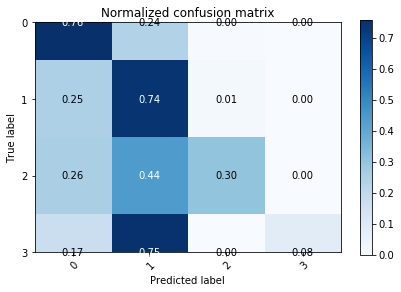

In [0]:
test_preds = model2.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2', '3'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.6802189210320563
Accuracy Balanceado: 0.47002464917531256


# MODEL 3

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(128,(5,5), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
model3 = get_model(num_classes=num_classes,reg=.0001, drop=0.4)
model3.summary()

using 4 classes
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 205, 173, 32)      544       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 102, 86, 32)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 102, 86, 32)       128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 99, 83, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 49, 41,

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model3', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model3.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model3.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,
          validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0427 21:46:02.497098 140301735864128 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0427 21:46:02.498308 140301735864128 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5121 samples, validate on 1279 samples
Epoch 1/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.5651 - accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 7.03675, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model3/best_model3.hdf5
5121/5121 [==============================] - 170s 33ms/sample - loss: 1.5650 - accuracy: 0.4029 - val_loss: 7.0367 - val_accuracy: 0.0719
Epoch 2/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.1907 - accuracy: 0.5363
Epoch 00002: val_loss improved from 7.03675 to 1.40236, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model3/best_model3.hdf5
5121/5121 [==============================] - 169s 33ms/sample - loss: 1.1907 - accuracy: 0.5362 - val_loss: 1.4024 - val_accuracy: 0.5340
Epoch 3/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.0547 - accuracy: 0.5924
Epoch 00003: val_loss did not improve from 1.40236
5121/5121 [==============================] - 

In [0]:
#Load the weights of the best stored model
model3.load_weights('best_model3.hdf5')

Normalized confusion matrix
[[0.5953125  0.4046875  0.         0.        ]
 [0.13169643 0.86383929 0.00446429 0.        ]
 [0.09497207 0.81005587 0.09497207 0.        ]
 [0.         1.         0.         0.        ]]


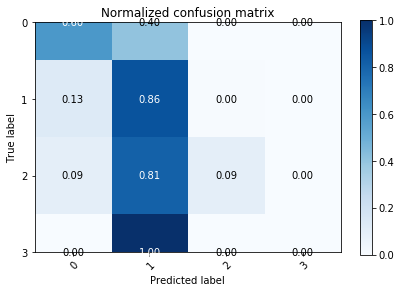

In [0]:
test_preds = model3.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2', '3'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.6137607505863957
Accuracy Balanceado: 0.38853096318834796


# MODEL 4

In [0]:
def get_model(num_classes, compile=True, reg=.0001, drop=0.4):

    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(208,176,1), name="input_1")
    layers = tf.keras.layers.Conv2D(16,(2,2), activation="relu", kernel_regularizer=l2(reg))(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Conv2D(32,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(64,(4,4), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Conv2D(128,(5,5), activation="relu", kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
model4 = get_model(num_classes=num_classes,reg=.0001, drop=0.4)
model4.summary()

using 4 classes
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 208, 176, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 207, 175, 16)      80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 103, 87, 16)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 103, 87, 16)       64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 84, 32)       8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 42, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 50, 42,

In [0]:
tb_callback = keras.callbacks.TensorBoard(log_dir='model4', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model4.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model4.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,
          validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0428 06:17:04.092815 140301735864128 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0428 06:17:04.093735 140301735864128 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5121 samples, validate on 1279 samples
Epoch 1/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.5912 - accuracy: 0.3990
Epoch 00001: val_loss improved from inf to 1.16144, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model4/best_model4.hdf5
5121/5121 [==============================] - 80s 16ms/sample - loss: 1.5912 - accuracy: 0.3989 - val_loss: 1.1614 - val_accuracy: 0.5113
Epoch 2/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.1901 - accuracy: 0.5244
Epoch 00002: val_loss improved from 1.16144 to 1.13457, saving model to /home/cristian/Cristian/Deep_learning/modelos_4c/model4/best_model4.hdf5
5121/5121 [==============================] - 78s 15ms/sample - loss: 1.1900 - accuracy: 0.5245 - val_loss: 1.1346 - val_accuracy: 0.4668
Epoch 3/20
5120/5121 [============================>.] - ETA: 0s - loss: 1.0510 - accuracy: 0.5650
Epoch 00003: val_loss did not improve from 1.13457
5121/5121 [==============================] - 78

In [0]:
#Load the weights of the best stored model
model4.load_weights('best_model4.hdf5')

Normalized confusion matrix
[[0.740625   0.2171875  0.0421875  0.        ]
 [0.27678571 0.625      0.09821429 0.        ]
 [0.18435754 0.44692737 0.36871508 0.        ]
 [0.58333333 0.25       0.16666667 0.        ]]


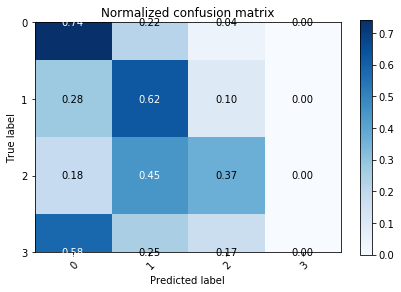

In [0]:
test_preds = model4.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2', '3'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.6411258795934324
Accuracy Balanceado: 0.4335850209497207


In [0]:
try:
    %load_ext tensorboard
    %tensorboard --logdir logs

except:
    print ("not in colab")

Reusing TensorBoard on port 6007 (pid 29689), started 1 day, 5:35:21 ago. (Use '!kill 29689' to kill it.)